# 02 - Evolving CartPole Controllers [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/02_mlp_control.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX on NVIDIA GPU with:

In [ ]:
%pip install -U "jax[cuda]"

Then, install `evosax` from PyPi:

In [ ]:
%pip install -U "evosax[examples]"

## Open-ES with MLP Controller

In [1]:
import jax
import jax.numpy as jnp
from evosax import PGPE, FitnessShaper, NetworkMapper, OpenES, ParameterReshaper
from evosax.problems import GymnaxProblem
from evosax.utils import ESLog

rng = jax.random.key(0)
network = NetworkMapper["MLP"](
    num_hidden_units=64,
    num_hidden_layers=2,
    num_output_units=2,
    hidden_activation="relu",
    output_activation="categorical",
)
solution = jnp.zeros((4,))
solution = network.init(
    rng,
    x=solution,
    rng=rng,
)

param_reshaper = ParameterReshaper(solution)

ParameterReshaper: 4610 parameters detected for optimization.


In [2]:
problem = GymnaxProblem("CartPole-v1", num_env_steps=200, num_rollouts=16)
problem.set_apply_fn(network.apply)

In [17]:
strategy = OpenES(
    population_size=100,
    num_dims=param_reshaper.total_params,
    opt_name="adam",
    lrate_init=0.1,
)
strategy.default_params

Params(opt_params=OptParams(lrate_init=0.1, lrate_decay=1.0, lrate_limit=0.001, momentum=None, beta_1=0.99, beta_2=0.999, beta_3=None, eps=1e-08, max_speed=None), sigma_init=0.03, sigma_decay=1.0, sigma_limit=0.01, init_min=0.0, init_max=0.0, clip_min=-3.4028235e+38, clip_max=3.4028235e+38)

In [18]:
num_generations = 100
print_every_k_gens = 20

es_logging = ESLog(
    param_reshaper.total_params, num_generations=num_generations, top_k=5, maximize=True
)
log = es_logging.init()

fit_shaper = FitnessShaper(centered_rank=True, w_decay=0.0, maximize=True)

state = strategy.init(rng)

for generation in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state)
    reshaped_params = param_reshaper.reshape(x)
    fitness = problem.rollout(rng_eval, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state)
    log = es_logging.update(log, x, fitness)

    if generation % print_every_k_gens == 0:
        print("Generation: ", generation, "Performance: ", log["log_top_1"][generation])

Generation:  0 Performance:  24.4375
Generation:  20 Performance:  200.0
Generation:  40 Performance:  200.0
Generation:  60 Performance:  200.0
Generation:  80 Performance:  200.0


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'CartPole MLP OpenAI-ES'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

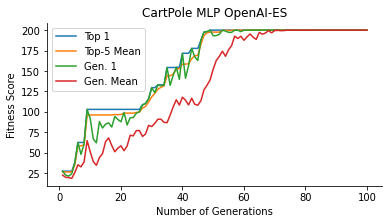

In [16]:
es_logging.plot(log, "CartPole MLP OpenAI-ES")

# PGPE with LSTM Controller

In [6]:
rng = jax.random.key(0)
network = NetworkMapper["LSTM"](
    num_hidden_units=32,
    num_output_units=2,
    output_activation="categorical",
)
solution = jnp.zeros((4,))
carry_init = network.init_carry()
solution = network.init(
    rng,
    x=solution,
    carry=carry_init,
    rng=rng,
)

param_reshaper = ParameterReshaper(solution)

ParameterReshaper: 4802 parameters detected for optimization.


In [7]:
problem = GymnaxProblem("CartPole-v1", num_env_steps=200, num_rollouts=16)
problem.set_apply_fn(network.apply, network.init_carry)

In [12]:
population_size = 100
strategy = PGPE(
    population_size, param_reshaper.total_params, elite_ratio=0.1, opt_name="adam"
)

# Update basic parameters of PGPE strategy
params = strategy.default_params
params

Params(opt_params=OptParams(lrate_init=0.05, lrate_decay=1.0, lrate_limit=0.001, momentum=None, beta_1=0.99, beta_2=0.999, beta_3=None, eps=1e-08, max_speed=None), sigma_init=0.03, sigma_decay=1.0, sigma_limit=0.01, sigma_lrate=0.2, sigma_max_change=0.2, init_min=0.0, init_max=0.0, clip_min=-3.4028235e+38, clip_max=3.4028235e+38)

In [13]:
num_generations = 100
print_every_k_gens = 20

es_logging = ESLog(
    param_reshaper.total_params, num_generations=num_generations, top_k=5, maximize=True
)
log = es_logging.init()

fit_shaper = FitnessShaper(w_decay=0.1, maximize=True)

state = strategy.init(rng, params)

for generation in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state, params)
    reshaped_params = param_reshaper.reshape(x)
    fitness = problem.rollout(rng_eval, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state, params)
    log = es_logging.update(log, x, fitness)

    if generation % print_every_k_gens == 0:
        print("Generation: ", generation, "Performance: ", log["log_top_1"][generation])

Generation:  0 Performance:  21.875
Generation:  20 Performance:  44.625
Generation:  40 Performance:  194.4375
Generation:  60 Performance:  199.3125
Generation:  80 Performance:  200.0


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'CartPole LSTM PGPE'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

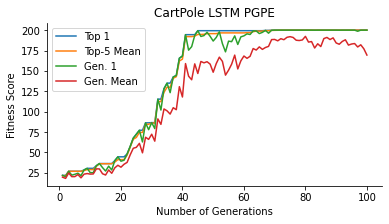

In [14]:
es_logging.plot(log, "CartPole LSTM PGPE")